In [2]:
# Install required packages
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

print("✅ All libraries imported successfully!")

c:\Users\HP\anaconda3\envs\myenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


✅ All libraries imported successfully!


In [4]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [5]:
sp500.index = pd.to_datetime(sp500.index)

In [6]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,0,0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,0,0
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,0,0


<Axes: xlabel='Date'>

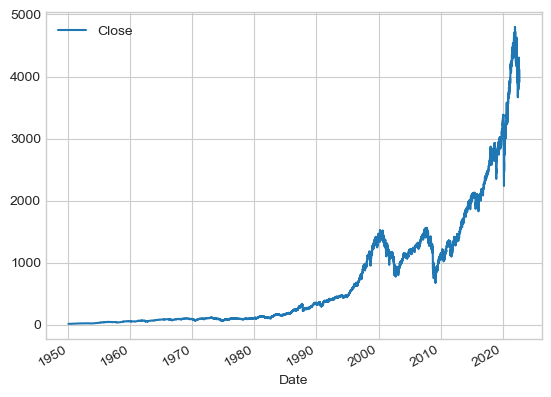

In [7]:
sp500.plot.line(y="Close", use_index=True)

In [8]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [9]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [10]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [11]:
sp500 = sp500.loc["1990-01-01":].copy()

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [13]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.47058823529411764

<Axes: xlabel='Date'>

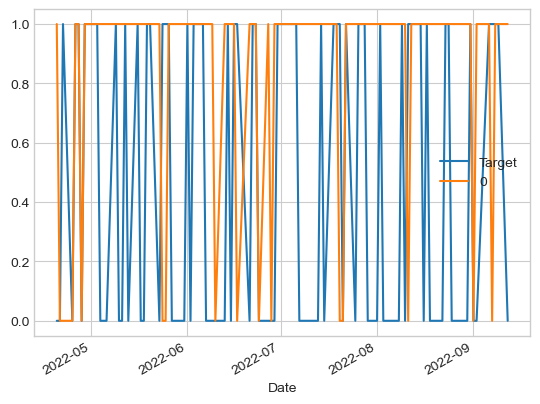

In [14]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [16]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [17]:
predictions = backtest(sp500, model, predictors)

In [18]:
predictions["Predictions"].value_counts()

Predictions
0    3337
1    2401
Name: count, dtype: int64

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.534777176176593

In [20]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536075
0    0.463925
Name: count, dtype: float64

In [21]:
# ============================================
# ADVANCED FEATURE ENGINEERING
# ============================================

# 1. Rolling Statistics Features
horizons = [2, 5, 10, 20, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    # Price Ratios
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    # Trend (cumulative target over horizon)
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    # Volume Ratio
    vol_ratio_column = f"Volume_Ratio_{horizon}"
    sp500[vol_ratio_column] = sp500["Volume"] / rolling_averages["Volume"]
    
    # Volatility (Rolling Std)
    volatility_column = f"Volatility_{horizon}"
    sp500[volatility_column] = sp500["Close"].rolling(horizon).std() / sp500["Close"]
    
    new_predictors += [ratio_column, trend_column, vol_ratio_column, volatility_column]

print(f"✅ Created {len(new_predictors)} rolling features")

✅ Created 28 rolling features


In [22]:
# ============================================
# TECHNICAL INDICATORS
# ============================================

# 2. RSI (Relative Strength Index)
def calculate_rsi(data, periods=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

sp500['RSI_14'] = calculate_rsi(sp500, 14)
sp500['RSI_7'] = calculate_rsi(sp500, 7)
sp500['RSI_21'] = calculate_rsi(sp500, 21)

# 3. MACD (Moving Average Convergence Divergence)
exp1 = sp500['Close'].ewm(span=12, adjust=False).mean()
exp2 = sp500['Close'].ewm(span=26, adjust=False).mean()
sp500['MACD'] = exp1 - exp2
sp500['MACD_Signal'] = sp500['MACD'].ewm(span=9, adjust=False).mean()
sp500['MACD_Histogram'] = sp500['MACD'] - sp500['MACD_Signal']

# 4. Bollinger Bands
sp500['BB_Middle'] = sp500['Close'].rolling(window=20).mean()
sp500['BB_Std'] = sp500['Close'].rolling(window=20).std()
sp500['BB_Upper'] = sp500['BB_Middle'] + (sp500['BB_Std'] * 2)
sp500['BB_Lower'] = sp500['BB_Middle'] - (sp500['BB_Std'] * 2)
sp500['BB_Width'] = (sp500['BB_Upper'] - sp500['BB_Lower']) / sp500['BB_Middle']
sp500['BB_Position'] = (sp500['Close'] - sp500['BB_Lower']) / (sp500['BB_Upper'] - sp500['BB_Lower'])

# 5. ATR (Average True Range) - Volatility Indicator
sp500['High_Low'] = sp500['High'] - sp500['Low']
sp500['High_Close'] = abs(sp500['High'] - sp500['Close'].shift())
sp500['Low_Close'] = abs(sp500['Low'] - sp500['Close'].shift())
sp500['True_Range'] = sp500[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
sp500['ATR_14'] = sp500['True_Range'].rolling(window=14).mean()
sp500['ATR_Ratio'] = sp500['ATR_14'] / sp500['Close']

# 6. Price Momentum
sp500['Momentum_5'] = sp500['Close'] / sp500['Close'].shift(5) - 1
sp500['Momentum_10'] = sp500['Close'] / sp500['Close'].shift(10) - 1
sp500['Momentum_20'] = sp500['Close'] / sp500['Close'].shift(20) - 1

# 7. Price Gaps
sp500['Gap'] = (sp500['Open'] - sp500['Close'].shift(1)) / sp500['Close'].shift(1)

# 8. Intraday Range
sp500['Intraday_Range'] = (sp500['High'] - sp500['Low']) / sp500['Open']
sp500['Body_Size'] = abs(sp500['Close'] - sp500['Open']) / sp500['Open']
sp500['Upper_Shadow'] = (sp500['High'] - sp500[['Close', 'Open']].max(axis=1)) / sp500['Open']
sp500['Lower_Shadow'] = (sp500[['Close', 'Open']].min(axis=1) - sp500['Low']) / sp500['Open']

# 9. Moving Average Crossovers
sp500['SMA_5'] = sp500['Close'].rolling(5).mean()
sp500['SMA_20'] = sp500['Close'].rolling(20).mean()
sp500['SMA_50'] = sp500['Close'].rolling(50).mean()
sp500['SMA_200'] = sp500['Close'].rolling(200).mean()
sp500['SMA_5_20_Cross'] = (sp500['SMA_5'] > sp500['SMA_20']).astype(int)
sp500['SMA_50_200_Cross'] = (sp500['SMA_50'] > sp500['SMA_200']).astype(int)
sp500['Price_Above_SMA200'] = (sp500['Close'] > sp500['SMA_200']).astype(int)

# Add technical indicators to predictors
technical_predictors = [
    'RSI_14', 'RSI_7', 'RSI_21',
    'MACD', 'MACD_Signal', 'MACD_Histogram',
    'BB_Width', 'BB_Position',
    'ATR_Ratio',
    'Momentum_5', 'Momentum_10', 'Momentum_20',
    'Gap', 'Intraday_Range', 'Body_Size', 'Upper_Shadow', 'Lower_Shadow',
    'SMA_5_20_Cross', 'SMA_50_200_Cross', 'Price_Above_SMA200'
]

new_predictors += technical_predictors
print(f"✅ Added {len(technical_predictors)} technical indicators")
print(f"📊 Total features: {len(new_predictors)}")

✅ Added 20 technical indicators
📊 Total features: 48


In [23]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [24]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Volume_Ratio_2,...,Body_Size,Upper_Shadow,Lower_Shadow,SMA_5,SMA_20,SMA_50,SMA_200,SMA_5_20_Cross,SMA_50_200_Cross,Price_Above_SMA200
Date,,,,,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,1.034742,...,0.005733,0.000837,0.001288,464.632001,463.664000,463.724399,453.335649,1,1,1
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,1.093471,...,0.002635,0.001361,0.000000,463.741998,463.419000,463.737198,453.398549,1,1,1
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.923506,...,0.003204,0.001386,0.000000,463.573999,463.345500,463.789199,453.478549,1,1,1
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.122045,...,0.006561,0.000000,0.000000,464.064001,463.483501,463.933199,453.579899,1,1,1
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,0.825950,...,0.001136,0.001115,0.000686,464.094000,463.646001,464.043999,453.635599,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,3936.729980,3970.229980,3903.649902,3966.850098,3754570000,3924.260010,0,1.001496,1.0,0.994268,...,0.007651,0.000859,0.008403,3999.256006,4154.843567,4017.634619,4293.439259,0,0,0
2022-09-02,3994.659912,4018.429932,3906.209961,3924.260010,4134920000,3908.189941,0,0.994603,1.0,1.048210,...,0.017624,0.005950,0.004519,3972.576025,4143.797070,4020.205220,4289.556060,0,0,0
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,3979.870117,1,0.997948,0.0,0.696579,...,0.005775,0.002966,0.005454,3948.091992,4132.203564,4020.134219,4285.653660,0,0,0


In [25]:
# ============================================
# MULTIPLE MODEL COMPARISON
# ============================================

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        min_samples_split=50, 
        max_depth=10,
        random_state=1,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=50,
        random_state=1
    )
}

print("✅ Models defined for comparison")
for name in models:
    print(f"   • {name}")

✅ Models defined for comparison
   • Random Forest
   • Gradient Boosting


In [26]:
# ============================================
# IMPROVED PREDICTION FUNCTION WITH PROBABILITY THRESHOLDS
# ============================================

def predict(train, test, predictors, model, threshold=0.6):
    """
    Enhanced prediction function with customizable probability threshold
    """
    model.fit(train[predictors], train["Target"])
    
    # Get probability predictions
    preds_proba = model.predict_proba(test[predictors])[:, 1]
    
    # Apply threshold
    preds = np.where(preds_proba >= threshold, 1, 0)
    
    preds = pd.Series(preds, index=test.index, name="Predictions")
    proba = pd.Series(preds_proba, index=test.index, name="Probability")
    
    combined = pd.concat([test["Target"], preds, proba], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250, threshold=0.6):
    """
    Enhanced backtesting with configurable parameters
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model, threshold)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

print("✅ Enhanced prediction and backtesting functions defined")

✅ Enhanced prediction and backtesting functions defined


In [27]:
# ============================================
# RUN BACKTEST FOR ALL MODELS
# ============================================

results = {}
best_model = None
best_precision = 0

for name, model in models.items():
    print(f"\n🔄 Running backtest for {name}...")
    predictions = backtest(sp500, model, new_predictors, threshold=0.55)
    results[name] = predictions
    
    precision = precision_score(predictions["Target"], predictions["Predictions"])
    recall = recall_score(predictions["Target"], predictions["Predictions"])
    f1 = f1_score(predictions["Target"], predictions["Predictions"])
    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
    
    print(f"   ✅ {name} Results:")
    print(f"      • Precision: {precision:.4f}")
    print(f"      • Recall: {recall:.4f}")
    print(f"      • F1 Score: {f1:.4f}")
    print(f"      • Accuracy: {accuracy:.4f}")
    
    if precision > best_precision:
        best_precision = precision
        best_model = name

print(f"\n🏆 Best Model: {best_model} with Precision: {best_precision:.4f}")


🔄 Running backtest for Random Forest...
   ✅ Random Forest Results:
      • Precision: 0.5579
      • Recall: 0.3631
      • F1 Score: 0.4399
      • Accuracy: 0.4945

🔄 Running backtest for Gradient Boosting...
   ✅ Gradient Boosting Results:
      • Precision: 0.5490
      • Recall: 0.4129
      • F1 Score: 0.4713
      • Accuracy: 0.4937

🏆 Best Model: Random Forest with Precision: 0.5579


In [28]:
predictions["Predictions"].value_counts()

Predictions
0    2789
1    1947
Name: count, dtype: int64

In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5490498202362609

In [30]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546664
0    0.453336
Name: count, dtype: float64

In [31]:
# ============================================
# COMPREHENSIVE MODEL EVALUATION
# ============================================

# Use best model predictions
predictions = results[best_model]

print(f"📊 Detailed Evaluation for {best_model}")
print("=" * 50)
print("\n📈 Classification Report:")
print(classification_report(predictions["Target"], predictions["Predictions"], 
                           target_names=["Down", "Up"]))

# Confusion Matrix
cm = confusion_matrix(predictions["Target"], predictions["Predictions"])
print("\n🔢 Confusion Matrix:")
print(cm)

📊 Detailed Evaluation for Random Forest

📈 Classification Report:
              precision    recall  f1-score   support

        Down       0.46      0.65      0.54      2147
          Up       0.56      0.36      0.44      2589

    accuracy                           0.49      4736
   macro avg       0.51      0.51      0.49      4736
weighted avg       0.51      0.49      0.49      4736


🔢 Confusion Matrix:
[[1402  745]
 [1649  940]]


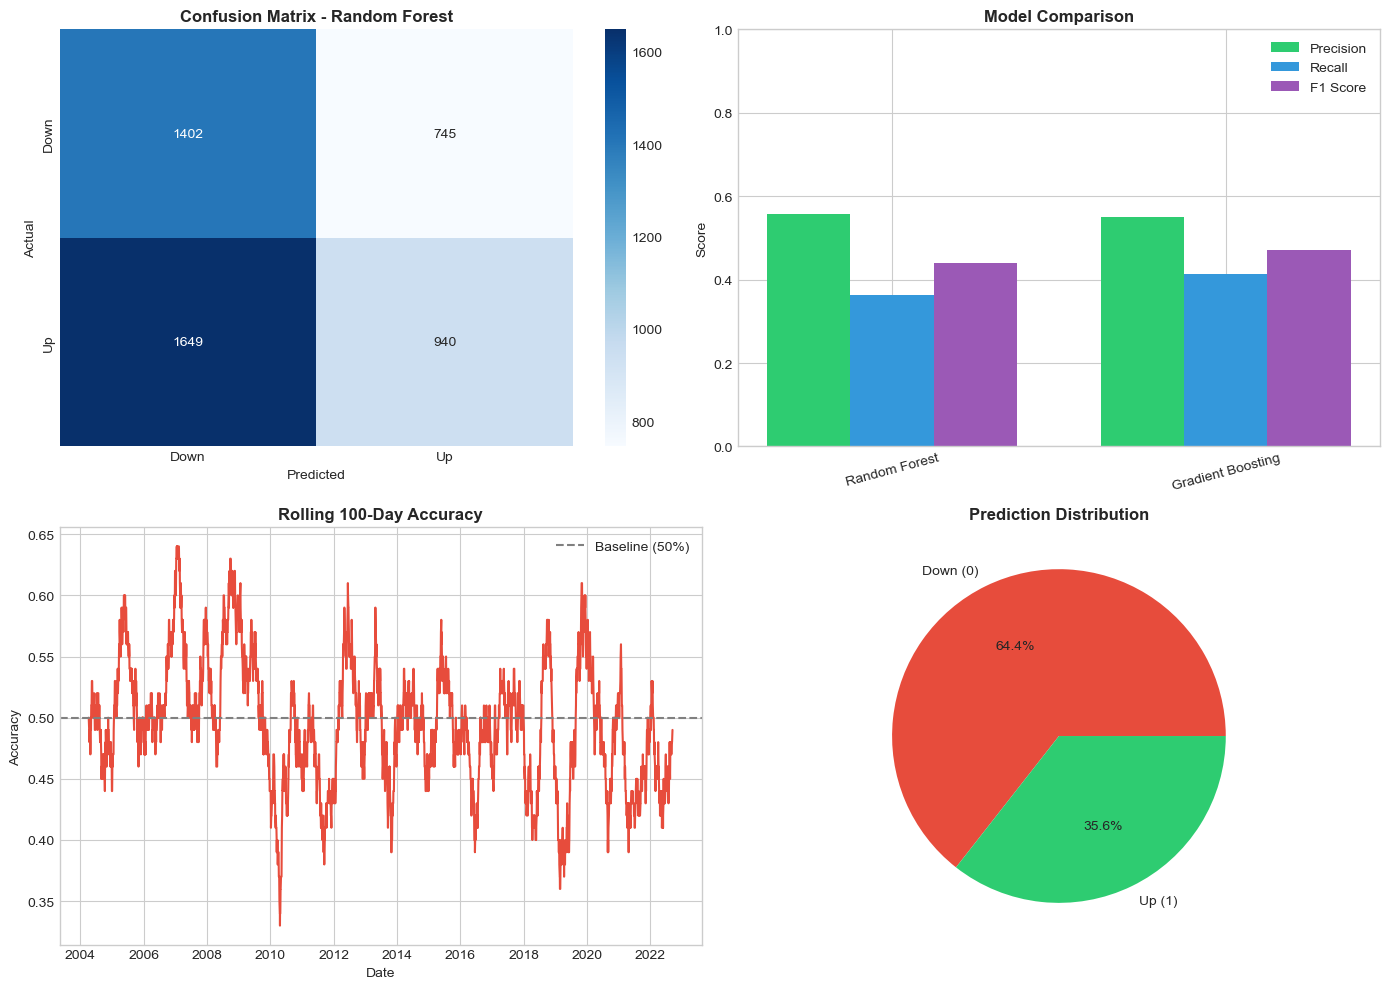

✅ Visualizations saved to 'model_performance.png'


In [32]:
# ============================================
# VISUALIZATIONS
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
ax1.set_title(f'Confusion Matrix - {best_model}', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# 2. Model Comparison
ax2 = axes[0, 1]
model_names = list(results.keys())
precisions = [precision_score(results[m]["Target"], results[m]["Predictions"]) for m in model_names]
recalls = [recall_score(results[m]["Target"], results[m]["Predictions"]) for m in model_names]
f1_scores = [f1_score(results[m]["Target"], results[m]["Predictions"]) for m in model_names]

x = np.arange(len(model_names))
width = 0.25

bars1 = ax2.bar(x - width, precisions, width, label='Precision', color='#2ecc71')
bars2 = ax2.bar(x, recalls, width, label='Recall', color='#3498db')
bars3 = ax2.bar(x + width, f1_scores, width, label='F1 Score', color='#9b59b6')

ax2.set_ylabel('Score')
ax2.set_title('Model Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=15)
ax2.legend()
ax2.set_ylim(0, 1)

# 3. Predictions vs Actual over Time (Rolling Accuracy)
ax3 = axes[1, 0]
predictions['Correct'] = (predictions['Target'] == predictions['Predictions']).astype(int)
rolling_accuracy = predictions['Correct'].rolling(100).mean()
ax3.plot(rolling_accuracy.index, rolling_accuracy.values, color='#e74c3c', linewidth=1.5)
ax3.axhline(y=0.5, color='gray', linestyle='--', label='Baseline (50%)')
ax3.set_title('Rolling 100-Day Accuracy', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Accuracy')
ax3.legend()

# 4. Prediction Distribution
ax4 = axes[1, 1]
predictions['Predictions'].value_counts().plot(kind='pie', ax=ax4, autopct='%1.1f%%',
                                                 colors=['#e74c3c', '#2ecc71'],
                                                 labels=['Down (0)', 'Up (1)'])
ax4.set_title('Prediction Distribution', fontsize=12, fontweight='bold')
ax4.set_ylabel('')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualizations saved to 'model_performance.png'")

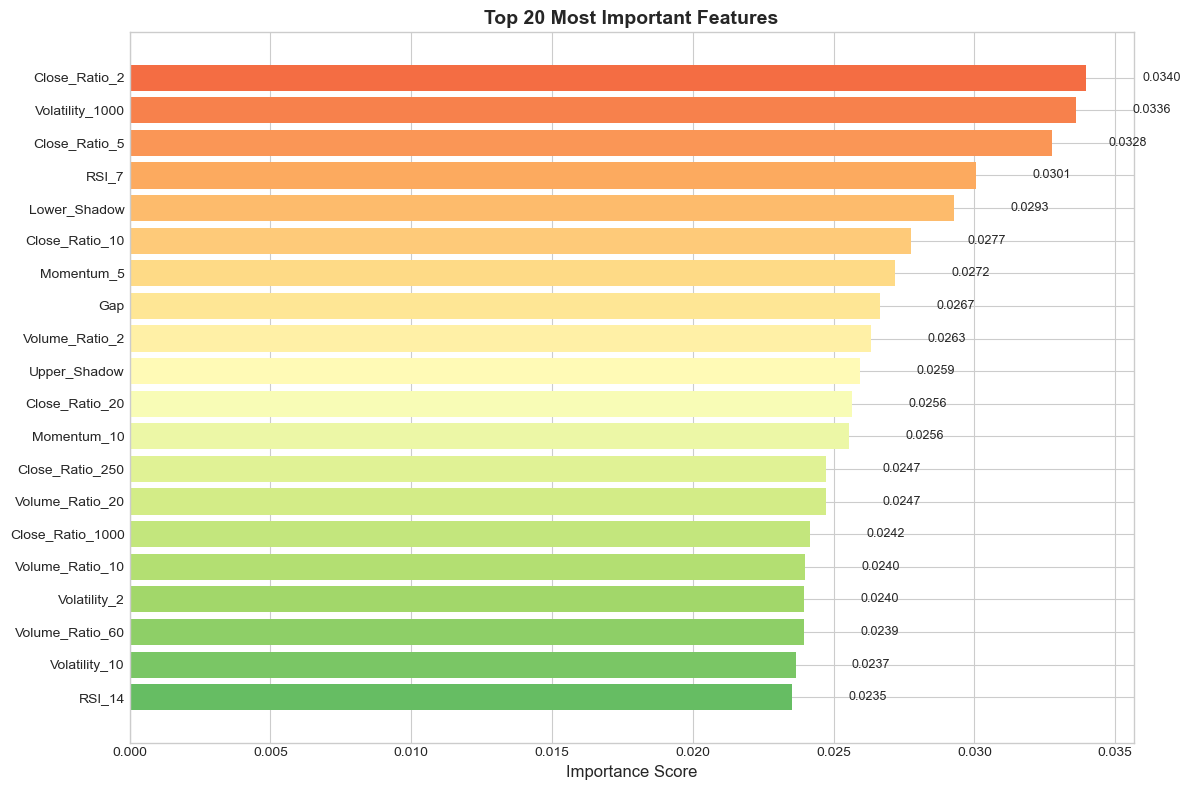


📊 Top 10 Most Important Features:
        Feature  Importance
  Close_Ratio_2    0.033959
Volatility_1000    0.033614
  Close_Ratio_5    0.032750
          RSI_7    0.030075
   Lower_Shadow    0.029283
 Close_Ratio_10    0.027743
     Momentum_5    0.027200
            Gap    0.026655
 Volume_Ratio_2    0.026345
   Upper_Shadow    0.025937


In [33]:
# ============================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================

# Train Random Forest on full data for feature importance
rf_model = models['Random Forest']
train_data = sp500.dropna(subset=new_predictors + ['Target'])
rf_model.fit(train_data[new_predictors], train_data['Target'])

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': new_predictors,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(top_20)))

bars = plt.barh(range(len(top_20)), top_20['Importance'].values, color=colors)
plt.yticks(range(len(top_20)), top_20['Feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_20['Importance'].values)):
    plt.text(val + 0.002, i, f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

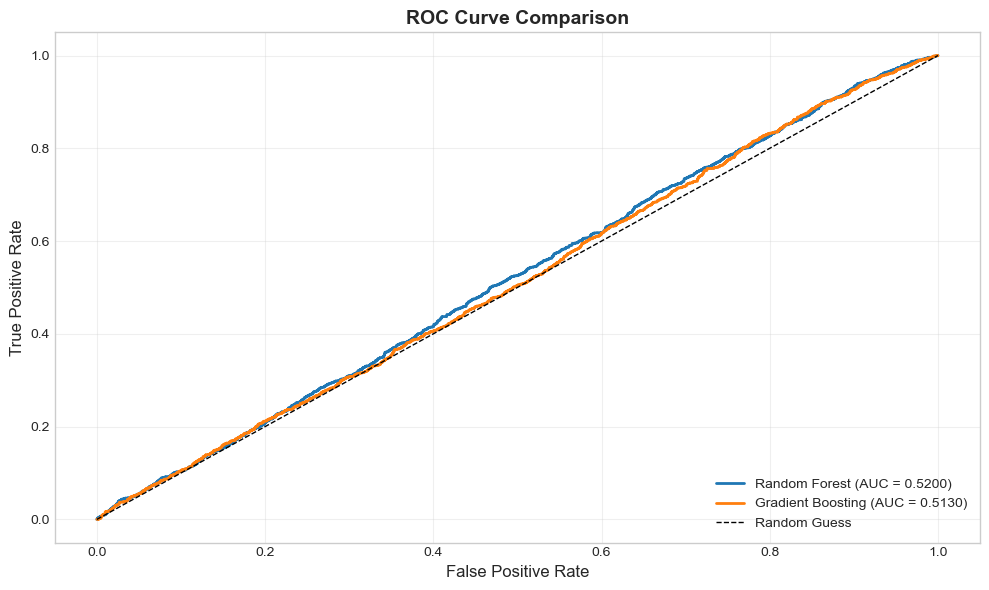

In [34]:
# ============================================
# ROC CURVE ANALYSIS
# ============================================

plt.figure(figsize=(10, 6))

for name in results:
    preds = results[name]
    if 'Probability' in preds.columns:
        fpr, tpr, _ = roc_curve(preds['Target'], preds['Probability'])
        auc_score = roc_auc_score(preds['Target'], preds['Probability'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

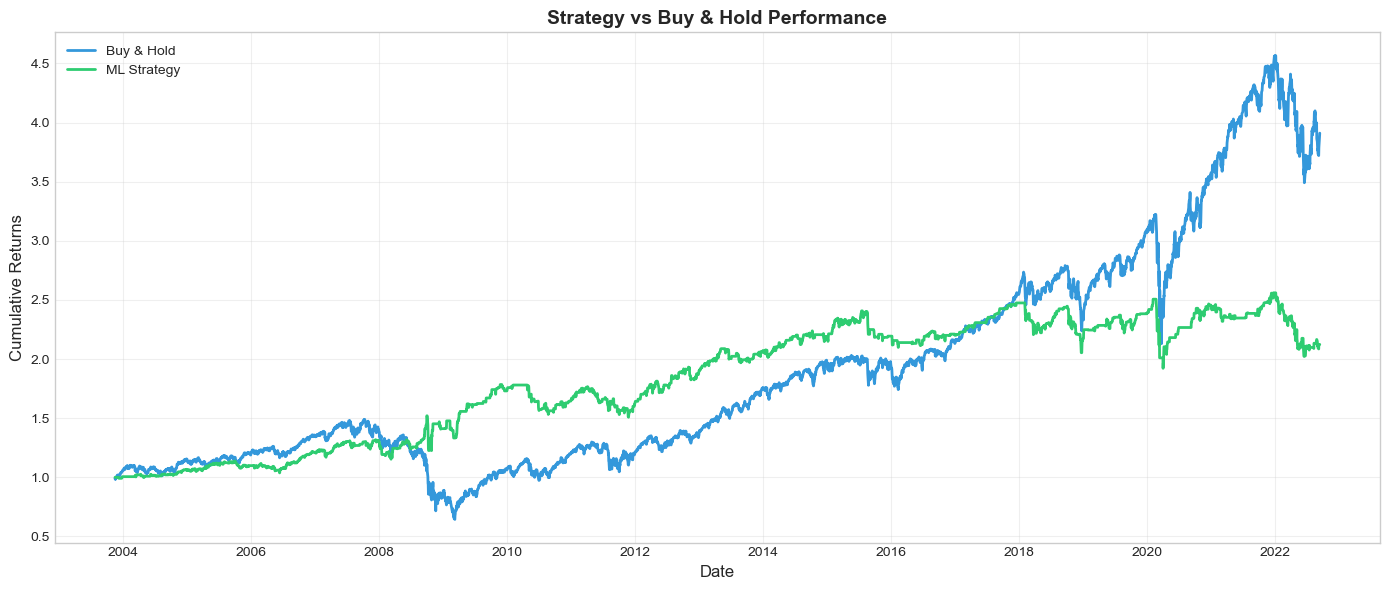

📈 TRADING PERFORMANCE SUMMARY
Metric                         Market          Strategy       
--------------------------------------------------
Total Return                         291.04%       112.37%
Sharpe Ratio (Annualized)            0.4737       0.4069
Max Drawdown                         -35.59%        -0.85%


In [35]:
# ============================================
# TRADING SIMULATION & RETURNS ANALYSIS
# ============================================

# Simulate trading based on predictions
predictions_with_returns = predictions.copy()
predictions_with_returns['Daily_Return'] = sp500.loc[predictions.index, 'Close'].pct_change()
predictions_with_returns['Strategy_Return'] = predictions_with_returns['Daily_Return'] * predictions_with_returns['Predictions'].shift(1)

# Calculate cumulative returns
predictions_with_returns['Cumulative_Market'] = (1 + predictions_with_returns['Daily_Return']).cumprod()
predictions_with_returns['Cumulative_Strategy'] = (1 + predictions_with_returns['Strategy_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 6))
plt.plot(predictions_with_returns.index, predictions_with_returns['Cumulative_Market'], 
         label='Buy & Hold', linewidth=2, color='#3498db')
plt.plot(predictions_with_returns.index, predictions_with_returns['Cumulative_Strategy'], 
         label='ML Strategy', linewidth=2, color='#2ecc71')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.title('Strategy vs Buy & Hold Performance', fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('strategy_returns.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate performance metrics
total_market_return = predictions_with_returns['Cumulative_Market'].iloc[-1] - 1
total_strategy_return = predictions_with_returns['Cumulative_Strategy'].iloc[-1] - 1
sharpe_market = predictions_with_returns['Daily_Return'].mean() / predictions_with_returns['Daily_Return'].std() * np.sqrt(252)
sharpe_strategy = predictions_with_returns['Strategy_Return'].mean() / predictions_with_returns['Strategy_Return'].std() * np.sqrt(252)

print("📈 TRADING PERFORMANCE SUMMARY")
print("=" * 50)
print(f"{'Metric':<30} {'Market':<15} {'Strategy':<15}")
print("-" * 50)
print(f"{'Total Return':<30} {total_market_return*100:>12.2f}% {total_strategy_return*100:>12.2f}%")
print(f"{'Sharpe Ratio (Annualized)':<30} {sharpe_market:>12.4f} {sharpe_strategy:>12.4f}")
print(f"{'Max Drawdown':<30} {(predictions_with_returns['Cumulative_Market'].min()-1)*100:>12.2f}% {(predictions_with_returns['Cumulative_Strategy'].min()-1)*100:>12.2f}%")